In [1]:
import numpy as np
# import nibabel as nib
import nilearn.plotting as plotting
# import nilearn.image as image
import matplotlib.pyplot as plt
# %matplotlib inline
import hcp_utils as hcp
from PIL import Image
import scipy
import pandas as pd
from plot_functions import *
import seaborn as sns

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [34]:
def crop_brain(file,bbox=[160,225,1100,955]):
    img = Image.open(file)
    img = img.crop(bbox)
    img.save(file)
    
def surf_montage(map,data,ref,modes,title):
    width = 940
    # montage
    montage = Image.new(mode='RGB', size=(len(modes)*width, 730)) #only works for lateral view
    for i,mode in enumerate(modes):
        if np.dot(data[:,mode],ref[:,mode])<0:
            data[:,mode] = -data[:,mode]
        plotting.plot_surf(map,#hcp.mesh.midthickness_left,
                        hcp.left_cortex_data(data[:,mode],fill=0),
                        cmap='seismic',
                        vmin = -0.015,
                        vmax = 0.015)#,bg_map=hcp.mesh.sulc_left
        plt.savefig('results/brainmaps/tmp/tmp'+str(mode+1)+'.png',dpi=300)
        plt.close()
        crop_brain('results/brainmaps/tmp/tmp'+str(mode+1)+'.png')
        montage.paste(im=Image.open('results/brainmaps/tmp/tmp'+str(mode+1)+'.png'), box=(i*width, 0))
        # print('mode '+str(mode+1)+' done')
    montage.save('results/brainmaps/'+title+'.png')


def parcellate_connectome(data):
    mask = np.loadtxt('BrainEigenmodes/data/template_surfaces_volumes/fsLR_32k_cortex-lh_mask.txt',dtype=bool)
    parcellation = np.loadtxt('BrainEigenmodes/data/parcellations/fsLR_32k_Schaefer200-lh.txt',dtype=int)[mask]
    uns = np.unique(parcellation[parcellation>0])
    newdata = np.zeros((len(uns),len(uns)))
    for i in range(len(uns)):
        for j in range(i+1,len(uns)):
            newdata[i,j] = np.sum(data[parcellation==uns[i],:][:,parcellation==uns[j]])
    return newdata+newdata.T

def plot_connectome1(data,title):
    data = parcellate_connectome(data)
    plotting.plot_matrix(data,labels=None,cmap='copper',colorbar=False,vmin=0,vmax=20000,tri='lower')
    #superimpose a white box at indices [50:75,25:50], in which the interior is shown and the box only has an outline
    plt.fill_between([25,50],50,75,color='white',alpha=0.3)
    #set xlabel
    plt.axis('off')
    plt.savefig('results/brainmaps/'+title+'.png',dpi=300)
    plt.close()

def plot_connectome2(data,title):
    data = parcellate_connectome(data)
    data = data[50:75,25:50]
    plotting.plot_matrix(data,labels=None,cmap='copper',colorbar=False,vmin=0,vmax=1500)
    #set xlabel
    plt.axis('off')
    plt.savefig('results/brainmaps/'+title+'.png',dpi=300)
    plt.close()

def prep_connectome(file):
    from connectome_eigenmodes import construct_A_local, threshold_edges_density
    surface_file = 'BrainEigenmodes/data/template_surfaces_volumes/fsLR_32k_midthickness-lh.vtk'
    mask_file = 'BrainEigenmodes/data/template_surfaces_volumes/fsLR_32k_cortex-lh_mask.txt'
    A_local = construct_A_local(surface_file,mask_file)
    W = scipy.sparse.load_npz(file)[:29696, :29696]
    W.setdiag(0)
    W.eliminate_zeros() 
    # W = threshold_edges_density(W, 0.001)
    # W = W + A_local
    # W[W>0] = 1
    return W

def plot_eigenvalues(evals,title):
    plt.figure(figsize=(7,5))
    plt.plot(1-evals)
    # plt.xlabel('Eigenvalue index')
    plt.ylabel('$1-\lambda$',fontsize=12)
    plt.ylim([0.85,1])
    plt.xlim([0,200])
    plt.xticks([0,200])
    # plt.set_xticklabels(['1','200'],fontsize=12)
    plt.yticks([0.9,1])
    # plt.set_yticklabels(['0.5','1'],fontsize=12)
    plt.savefig('results/brainmaps/'+title+'.png',dpi=300)
    plt.close()

In [3]:
modes = [0,1,2,3,49,99,199]
mask = np.loadtxt('BrainEigenmodes/data/template_surfaces_volumes/fsLR_32k_cortex-lh_mask.txt',dtype=bool)
# map = hcp.mesh.midthickness_left
mesh_sub = 'data/100307/T1w/fsaverage_LR32k/100307.L.midthickness_MSMAll.32k_fs_LR.surf.gii'
a = np.loadtxt('data/100307/T1w/fsaverage_LR32k/100307.L.midthickness_MSMAll.32k_fs_LR_emodes.txt')[mask]
# surf_montage(mesh_sub,a,a,modes,'100307_fsLR_32k_midthickness-lh_emode_200')
# b = np.loadtxt('results/avg_connectomes/100307_structural_connectome_20M_fwhm0.0_emodes.txt')
b = np.loadtxt('data/100307/T1w/tractography_eigenmodes/100307_structural_connectome_20M_fwhm0.0_elocal1.0_density0.001_binary_emodes.txt')
surf_montage(mesh_sub,b,a,modes,'100307_structural_connectome_20M_fwhm0.0_elocal1.0_density0.001_weighted_emodes')
# c = np.loadtxt('results/avg_connectomes/avg_structural_connectome_20M_fwhm0.0_100_emodes.txt')
c = np.loadtxt('results/avg_connectomes/avg_structural_connectome_20M_fwhm0.0_elocal1.0_density0.001_binary_emodes_100.txt')
surf_montage(mesh_sub,c,a,modes,'avg_structural_connectome_20M_fwhm0.0_elocal1.0_density0.001_weighted_emodes_100')

In [35]:
file = 'data/100307/T1w/tractography/100307_unsmoothed_high_resolution_volumetric_probabilistic_track_endpoints_20M.tck_structural_connectivity.npz'
# file = 'data/100307/T1w/tractography/100307_smoothed_structural_connectome_20M_fwhm8.0.npz'
W = prep_connectome(file)
plot_connectome1(W,'100307_structural_connectome_20M_fwhm0.0_mat_tri')
plot_connectome2(W,'100307_structural_connectome_20M_fwhm0.0_mat_zoom')

file = 'results/avg_connectomes/avg_structural_connectome_20M_fwhm0.0_100.npz'
# file = 'results/avg_connectomes/avg_structural_connectome_20M_fwhm8.0_100.npz'
W = prep_connectome(file)
plot_connectome1(W,'avg_structural_connectome_20M_fwhm0.0_mat_100_tri')
plot_connectome2(W,'avg_structural_connectome_20M_fwhm0.0_mat_100_zoom')

--> VTK format         ... 
 --> DONE ( V: 32492 , T: 64980 )

--> VTK format         ... 
 --> DONE ( V: 32492 , T: 64980 )



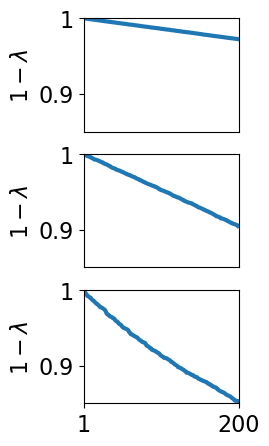

In [21]:
evals =[]
evals.append(np.loadtxt('data/100307/T1w/Native/100307.L.midthickness.native_eval.txt'))
evals.append(np.loadtxt('results/avg_connectomes/avg_structural_connectome_20M_fwhm0.0_100_emodes_evals.txt'))
evals.append(np.loadtxt('results/avg_connectomes/100307_structural_connectome_20M_fwhm0.0_emodes_evals.txt'))


fig,axs = plt.subplots(3,1,figsize=(2,5))
for i in range(3):
    axs[i].plot(1-evals[i],linewidth=3)
    axs[i].set_ylabel('$1-\lambda$',fontsize=16)
    axs[i].set_ylim([0.85,1])
    axs[i].set_xlim([0,200])
    if i<2:
        axs[i].set_xticks([])
        axs[i].set_xticklabels([],fontsize=16)
    else:
        axs[i].set_xticks([0,200])
        axs[i].set_xticklabels(['1','200'],fontsize=16)
    axs[i].set_yticks([0.9,1])
    axs[i].set_yticklabels(['0.9','1'],fontsize=16)
plt.savefig('results/brainmaps/evals.png',dpi=300,bbox_inches='tight')

In [6]:
plotting.plot_surf('data/100307/T1w/100307/surf/lh.graymid.surf.gii',
                   surf_map='data/100307/T1w/100307/surf/lh.sulc',
                   cmap='Greys')#
plt.savefig('results/brainmaps/midthickness.png',dpi=300)
plt.close()
crop_brain('results/brainmaps/midthickness.png',bbox=[120,215,1120,965])

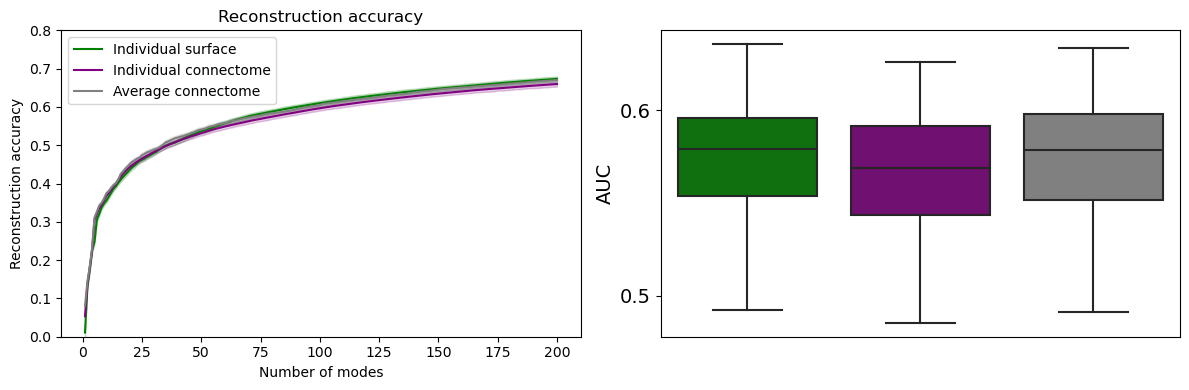

In [2]:
#warnings off
import warnings
warnings.filterwarnings("ignore")
df = pd.read_pickle('reconstruction_accuracies100.pkl')
# task, subject-specific
exp_settings = {'basis':['subject-specific','avg connectome basis','ind. surface'],
                'e_local':['1.0','none'],
                'density':['0.01','none'],
                'binarization':['binary','none'],
                'fwhm':['8.0','none'],
                'contrast':np.loadtxt('contrast_list.txt',dtype=str),
                'streamlines':['20M','none']}
df2 = filter_df(df,exp_settings)
df2 = rename_df(df2)
df_plot,df_AUC = convert_df(df2,do_df_plot=True)
df_plot,df_AUC = avg_over_tasks(df_plot,df_AUC,which=0,do_df_plot=True)

fig, axs = plt.subplots(1,2,figsize=(12, 4))
custom_palette = ["green", "purple", "gray"]
# plt.suptitle(title)
sns.lineplot(x='Number of modes',y='Reconstruction accuracy', data=df_plot, ax=axs[0],palette=custom_palette,hue='Basis',markers=True,hue_order=['Individual surface','Individual connectome','Average connectome'])
axs[0].legend(loc='upper left')
# axs[0].set_xlabel('Method')
axs[0].set_ylabel('Reconstruction accuracy')
axs[0].set_ylim([0,0.8])
axs[0].set_title('Reconstruction accuracy')
plt.tight_layout()
# custom_palette = ["gray","purple","green"]
sns.boxplot(x='Basis',y='Reconstruction accuracy',data=df_AUC,ax=axs[1],palette=custom_palette)
axs[1].set_ylabel('AUC',fontsize=14)
axs[1].set_xlabel('')
axs[1].set_xticks([])
axs[1].set_xticklabels([])
axs[1].set_yticks([0.50,0.60])
axs[1].set_yticklabels([0.50,0.60],fontsize=14)
# axs[1].set_ylim(ylim)
# axs[1].set_title('Area under the curve (AUC)',size=16)
plt.tight_layout()
plt.savefig('results/brainmaps/reconstruction_accuracies_best.png',dpi=300)

In [8]:
def save_overlays(mesh_sub,data,title,vmin,vmax):
    mask = np.loadtxt('BrainEigenmodes/data/template_surfaces_volumes/fsLR_32k_cortex-lh_mask.txt',dtype=bool)
    plotting.plot_surf(mesh_sub,hcp.left_cortex_data(data[mask],fill=0),cmap='seismic',vmin=vmin,vmax=vmax)#
    plt.savefig('results/brainmaps/'+title+'.png',dpi=300)
    plt.close()
    crop_brain('results/brainmaps/'+title+'.png')


social_random done
social_tom done
social_tom_random done
motor_cue done
motor_lf done
motor_lh done
motor_rf done
motor_rh done
motor_t done
motor_avg done
motor_cue_avg done
motor_lf_avg done
motor_lh_avg done
motor_rf_avg done
motor_rh_avg done
motor_t_avg done
gambling_punish done
gambling_reward done
gambling_punish_reward done
wm_2bk_body done
wm_2bk_face done
wm_2bk_place done
wm_2bk_tool done
wm_0bk_body done
wm_0bk_face done
wm_0bk_place done
wm_0bk_tool done
wm_2bk done
wm_0bk done
wm_2bk_0bk done
wm_body done
wm_face done
wm_place done
wm_tool done
wm_body_avg done
wm_face_avg done
wm_place_avg done
wm_tool_avg done
language_math done
language_story done
language_math_story done
emotion_faces done
emotion_shapes done
emotion_faces_shapes done
relational_match done
relational_rel done
relational_match_rel done
SSBCAP1 done
SSBCAP2 done
SSBCAP3 done
SSBCAP4 done
SSBCAP5 done
SSBCAP6 done
SSBCAP7 done
SSBCAP8 done
SSBCAP9 done
SSBCAP10 done
SSBCAP11 done
SSBCAP12 done
SSBCAP13 

KeyboardInterrupt: 

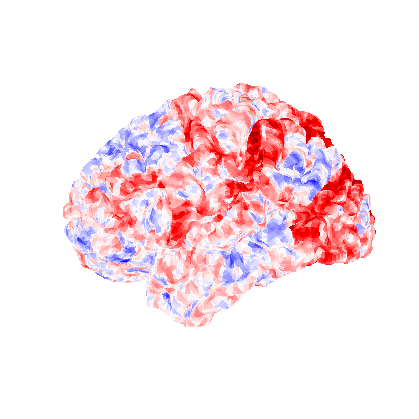

In [9]:
#map of task
mesh_sub = 'data/100307/T1w/fsaverage_LR32k/100307.L.midthickness_MSMAll.32k_fs_LR.surf.gii'

contrasts = np.loadtxt('contrast_list.txt',dtype=str)
for contrast in contrasts:
    a = np.loadtxt('data/100307/task_txtfiles/'+contrast+'.txt')
    save_overlays(mesh_sub,a,'tasks/'+contrast,vmin=-10,vmax=10)
    print(contrast+' done')

#map of SSBCAP
for i in range(200):
    a = np.loadtxt('data/100307/T1w/Results/SBBCAPs/lh.rfMRI_REST1_LR.res1250.spaceT1w.detrend1_regMov1_zscore1.SSBCAPs_schaefer400yeo7_res1250_spaceT1w_reg'+str(i+1)+'.txt')
    save_overlays(mesh_sub,a,'SSBCAPs/SSBCAP'+str(i+1),vmin=-0.5,vmax=0.5)
    print('SSBCAP'+str(i+1)+' done')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
a = np.arange(-10,11).repeat(10).reshape(10,21)
cax = ax.imshow(a,cmap='seismic')
cbar = fig.colorbar(cax,ticks=[-10,10])
plt.savefig('results/brainmaps/seismic_cbar.png',dpi=300)
plt.close()
